In [2]:
import numpy as np
import pandas as pd
from Modelling.CrossValidation import PurgedKFold, cvScore
from sklearn.metrics import log_loss, accuracy_score
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from HighPerformanceComputing.MultiprocessingAndVectorization import mpPandasObj
from itertools import product
import matplotlib.pyplot as plt

In [3]:
def featImpMDI(fit, featNames):
    """
    Este método determina la importancia de las características basado en la reducción de impureza media IS (in-sample).
    Nota: Este método solo es aplicable a clasificadores basados en Bosques Aleatorios (Random Forest)
    :param fit: clasificador tipo Random Forest
    :param featNames: lista que contiene el nombre de las características
    :return: DataFrame con la importancia de cada característica
    """
    df0 = {i: tree.feature_importances_ for i, tree in enumerate(fit.estimators_)}
    df0 = pd.DataFrame.from_dict(df0, orient="index")
    df0.columns = featNames
    df0 = df0.replace(0, np.nan)  # Debido a max_features = 1
    imp = pd.concat({"mean": df0.mean(), "std": df0.std() * df0.shape[0]**(-0.5)}, axis=1)
    imp /= imp["mean"].sum()
    return imp


def featImpMDA(clf, X, y, cv, sample_weight, t1, pctEmbargo=0.01, scoring='neg_log_loss'):
    """
    Método que determina la importancia de las características basado en la reducción de puntaje OOS (out-of-sample)
    Puede ser aplicado a clasificadores de cualquier tipo, no solo en clasificadores basados en árboles.
    :param clf: clasificador
    :param X: DataFrame con las características de entrada
    :param y: DataFrame con las etiquetas de entrenamiento
    :param cv: número de divisiones para la clasificación cruzada
    :param sample_weight: pesos de muestra para una Diferenciación Fraccional de Características (FDF)
    :param t1: DataFrame con las etiquetas de inicio y fin de cada evento
    :param pctEmbargo: porcentaje de embargo para evitar el solape en la validación cruzada
    :param scoring: tipo de puntuación
    :return: DataFrame con la importancia de cada características y la media del puntaje
    """
    # Importancia de características basado en la reducción de puntaje OOS (out-of-sample)
    if scoring not in ['neg_log_loss', 'accuracy']:
        raise Exception('Método de puntaje erróneo. Debería ser "neg_log_los" o "accuracy".')
    cvGen = PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo)  # Validación Cruzada purgada.
    scr0 = pd.Series()
    scr1 = pd.DataFrame(columns=X.columns)
    for i, (train, test) in enumerate(cvGen.split(X=X)):
        X0, y0, w0 = X.iloc[train, :], y.iloc[train], sample_weight.iloc[train]
        X1, y1, w1 = X.iloc[test, :], y.iloc[test], sample_weight.iloc[test]
        fit = clf.fit(X=X0, y=y0, sample_weight=w0.values)
        if scoring == 'neg_log_loss':
            prob = fit.predict_proba(X1)
            scr0.loc[i] = -log_loss(y1, prob, sample_weight=w1.values, labels=clf.classes_)
        else:
            pred = fit.predict(X1)
            scr0.loc[i] = accuracy_score(y1, pred, sample_weight=w1.values)
        for j in X.columns:
            X1_ = X1.copy(deep=True)
            np.random.shuffle(X1_[j].values)  # Permutación de una sola columna.
            if scoring == 'neg_log_loss':
                prob = fit.predict_proba(X1_)
                scr1.loc[i, j] = -log_loss(y1, prob, sample_weight=w1.values,
                                   labels=clf.classes_)
            else:
                pred = fit.predict(X1_)
                scr1.loc[i, j] = accuracy_score(y1, pred, sample_weight=w1.values)
    imp = (-scr1).add(scr0, axis=0)
    if scoring == 'neg_log_loss':
        imp = imp / -scr1
    else:
        imp = imp / (1. - scr1)
    imp = pd.concat({'mean': imp.mean(), 'std': imp.std() * imp.shape[0] ** -.5}, axis=1)
    return imp, scr0.mean()


def auxFeatImpSFI(featNames, clf, trnsX, cont, scoring, cvGen):
    """
    SFI (Single Feature Importance) - Importancia de una sola característica
    Computa el rendimiento OOS para cada característica en aislamiento
    Nota: su principal ventaja estriba en que no sufre el efecto de sustitución. Por lo que, cuando se halle dos
    características con igual rendimiento, una de ellas no sería eliminada.
    :param featNames: lista con los nombres de las características
    :param clf: clasificador
    :param trnsX: DataFrame con los las características de entrada
    :param cont: DataFrame con las etiquetas
    :param scoring: tipo de puntaje
    :param cvGen: Generador de cv proveniente de las extención de la clase KFold de sklearn.
    :return: DataFrame con las importacia de cada característica.
    """
    imp = pd.DataFrame(columns=['mean', 'std'])
    for featName in featNames:
        df0 = cvScore(clf, X=trnsX[[featName]], y=cont['bin'], sample_weight=cont['w'], scoring=scoring, cvGen=cvGen)
        imp.loc[featName,'mean'] = df0.mean()
        imp.loc[featName,'std'] = df0.std()*df0.shape[0]**-.5
    return imp


def get_eVec(dot,varThres):
    """
    Obtener los eigen vectores
    :param dot: matriz de producto punto
    :param varThres: porcentaje de varianza que deben explicar las características ortogonales
    :return: DataFrame de eigen-valores y DataFrame de eigen-vectores
    """
    # 1) Computar eigen-vectores (eVec) de la matriz de producto punto, reducir dimensiones.
    eVal, eVec = np.linalg.eigh(dot)  # Acá ocurre la magia del álgebra lineal
    idx = eVal.argsort()[::-1]  # Argumentos para ordenar descendiente eVal
    eVal, eVec = eVal[idx], eVec[:, idx]
    # 2) Solo eVals positivos
    eVal = pd.Series(eVal, index=['PC_'+str(i+1) for i in range(eVal.shape[0])])
    eVec = pd.DataFrame(eVec, index=dot.index, columns=eVal.index)
    eVec = eVec.loc[:, eVal.index]
    # 3) Reducir dimensiones, formar Componentes Principales (PC: Principal Components)
    cumVar = eVal.cumsum() / eVal.sum()
    dim = cumVar.values.searchsorted(varThres)
    eVal, eVec = eVal.iloc[:dim+1], eVec.iloc[:, :dim+1]
    return eVal, eVec


def orthoFeats(dfX,varThres = .95):
    """
    Carácterísticas ortogonales
    :param dfX: DataFrame de características
    :param varThres: porcentaje de varianza que deben explicar las características ortogonales
    :return: DataFrame con las orto-características.
    """
    # Dado un DataFrame dfX de características, computar las orto-características dfP
    dfZ = dfX.sub(dfX.mean(), axis=1).div(dfX.std(), axis=1)  # Estandarizar: (X - mu) / sigma
    dot = pd.DataFrame(np.dot(dfZ.T, dfZ), index=dfX.columns, columns=dfX.columns)
    eVal, eVec = get_eVec(dot, varThres)
    dfP = np.dot(dfZ, eVec)
    return dfP


def getTestData(n_features=40, n_informative=10, n_redundant=10, n_samples=10000):
    """
    Genera un conjunto de datos aleatorios para un problema de clasificación
    :param n_features: número de características
    :param n_informative: número de características que aportan información
    :param n_redundant: número de características función de las anteriores
    :param n_samples: número de muestras
    :return: DataFrame con muestras generadas y otro DataFrame con las etiquetas de enteros para la
                pertenencia a clase de cada muestra.
    """
    trnsX, cont = make_classification(n_samples=n_samples,
                                      n_features=n_features,
                                      n_informative=n_informative,
                                      n_redundant=n_redundant,
                                      random_state=0,
                                      shuffle=False)

    df0 = pd.DatetimeIndex(periods=n_samples,
                           freq=pd.tseries.offsets.BDay(),
                           end=pd.datetime.today()
                           )
    trnsX = pd.DataFrame(trnsX, index=df0)
    cont = pd.Series(cont, index=df0).to_frame("bin")
    df0 = ["i_" + str(i) for i in range(n_informative)] + ["R_" + str(i) for i in range(n_redundant)]
    df0 += ["N_" + str(i) for i in range(n_features - len(df0))]
    trnsX.columns = df0
    cont["w"] = 1.0 / cont.shape[0]
    cont["t1"] = pd.Series(cont.index, index=cont.index)
    return trnsX, cont


def featImportance(trnsX, cont, n_estimators=1000, cv=10, max_samples=1., numThreads=24,
        pctEmbargo=0, scoring='accuracy', method='SFI', minWLeaf=0., **kargs):
    """
    Importancia de características desde un Bosque Aleatorio
    :param trnsX: DataFrame de características
    :param cont: DataFrame de etiquetas
    :param n_estimators: número de estimadores
    :param cv: número de divisiones para la validación cruzada
    :param max_samples: máximo número de muestras
    :param numThreads: número de procesos paralelos
    :param pctEmbargo: porcentaje de embargo para evitar solape de eventos
    :param scoring: tipo de puntuación
    :param method: método para determinar la importancia de las características
    :param minWLeaf:
    :param kargs:
    :return:
    """
    n_jobs = (-1 if numThreads > 1 else 1)  # Corre 1 proceso con ht_helper en dirac1
    # 1) Preparar el clasificador, cv, max_features=1, para prevenir enmascarado
    clf = DecisionTreeClassifier(criterion='entropy',
                                 max_features=1,
                                 class_weight='balanced',
                                 min_weight_fraction_leaf=minWLeaf)
    clf = BaggingClassifier(base_estimator=clf,
                            n_estimators=n_estimators,
                            max_features=1.,
                            max_samples=max_samples,
                            oob_score=True,
                            n_jobs = n_jobs)
    fit = clf.fit(X=trnsX, y=cont['bin'], sample_weight=cont['w'].values)
    oob = fit.oob_score_
    if method == 'MDI':
        imp = featImpMDI(fit, featNames=trnsX.columns)
        oos = cvScore(clf,
                      X=trnsX,
                      y=cont['bin'],
                      cv=cv,
                      sample_weight=cont['w'],
                      t1=cont['t1'],
                      pctEmbargo=pctEmbargo,
                      scoring=scoring).mean()
    elif method == 'MDA':
        imp, oos = featImpMDA(clf,
                              X=trnsX,
                              y=cont['bin'],
                              cv=cv,
                              sample_weight=cont['w'],
                              t1=cont['t1'],
                              pctEmbargo=pctEmbargo,
                              scoring=scoring)
    elif method == 'SFI':
        cvGen = PurgedKFold(n_splits=cv, t1=cont['t1'], pctEmbargo=pctEmbargo)
        oos = cvScore(clf,
                      X=trnsX,
                      y=cont['bin'],
                      sample_weight=cont['w'],
                      scoring=scoring,
                      cvGen=cvGen).mean()
        clf.n_jobs = 1  # Paralelizar auxFeatImpSFI en de clf
        imp = mpPandasObj(auxFeatImpSFI,
                          ('featNames', trnsX.columns),
                          numThreads,
                          clf=clf,
                          trnsX=trnsX,
                          cont=cont,
                          scoring=scoring,
                          cvGen=cvGen)
    return imp, oob, oos


def testFunc(n_features=40, n_informative=10, n_redundant=10, n_estimators=1000, n_samples=10000, cv=10):
    """
    Prueba el rendimiento de las funciones de importancia de características sobre datos artificiales.
    :param n_features:
    :param n_informative: número de características que aportan información
    :param n_redundant: número de características función de las anteriores
    :param n_estimators: números de estimadores
    :param n_samples: número de muestras
    :param cv: número de divisiones para la validación cruzada
    :return:
    """
    # Número de características ruido = n_features— n_informative — n_redundant
    trnsX, cont = getTestData(n_features, n_informative, n_redundant, n_samples)
    dict0 = {'minWLeaf': [0.],
             'scoring': ['accuracy'],
             'method': ['MDI', 'MDA', 'SFI'],
             'max_samples': [1.]}
    jobs, out = (dict(zip(dict0, i)) for i in product(*dict0.values())), []
    kargs = {'pathOut': './',
             'n_estimators': n_estimators,
             'tag': 'testFunc',
             'cv': cv}
    for job in jobs:
        job['simNum'] = job['method'] + '_' + job['scoring'] + '_' + '%.2f' % job['minWLeaf'] + \
                        '_' + str(job['max_samples'])
        print(job['simNum'])
        kargs.update(job)
        imp, oob, oos = featImportance(trnsX=trnsX, cont=cont, **kargs)
        plotFeatImportance(imp=imp, oob=oob, oos=oos, **kargs)
        df0 = imp[['mean']] / imp['mean'].abs().sum()
        df0['type'] = [i[0] for i in df0.index]
        df0 = df0.groupby('type')['mean'].sum().to_dict()
        df0.update({'oob': oob, 'oos': oos})
        df0.update(job)
        out.append(df0)
    out = pd.DataFrame(out).sort_values(['method', 'scoring', 'minWLeaf', 'max_samples'])
    out = out['method', 'scoring', 'minWLeaf', 'max_samples', 'I', 'R', 'N', 'oob', 'oos']
    out.to_csv(kargs['pathOut'] + 'stats.csv')
    return


def plotFeatImportance(pathOut, imp, oob, oos, method, tag=0, simNum=0, **kargs):
    """
    Plotear la media de barras importantes con desviación estándar
    :param pathOut:
    :param imp:
    :param oob:
    :param oos:
    :param method:
    :param tag:
    :param simNum:
    :param kargs:
    :return:
    """
    plt.figure(figsize=(10, imp.shape[0]/5.))
    imp = imp.sort_values('mean',ascending=True)
    ax = imp['mean'].plot(kind='barh', color='b', alpha=.25, xerr=imp['std'], error_kw={'ecolor': 'r'})
    if method == 'MDI':
        plt.xlim([0, imp.sum(axis = 1).max()])
        plt.axvline(1./imp.shape[0], linewidth=1, color='r', linestyle='dotted')
    ax.get_yaxis().set_visible(False)
    for i, j in zip(ax.patches, imp.index):
        ax.text(i.get_width()/2,
                i.get_y()+i.get_height()/2,
                j,
                ha='center',
                va='center',
                color='black')
    plt.title('tag = '+ tag + ' | simNum = ' + str(simNum) + ' | oob = ' + str(round(oob, 4)) +
        ' | oos = ' + str(round(oos, 4)))
    plt.savefig(pathOut + 'featImportance_' + str(simNum) + '.png', dpi=100)
    plt.clf()
    plt.close()
    return

In [11]:
def featImpMDI(fit, featNames):
    """
    Este método determina la importancia de las características basado en la reducción de impureza media IS (in-sample).
    Nota: Este método solo es aplicable a clasificadores basados en Bosques Aleatorios (Random Forest)
    :param fit: clasificador tipo Random Forest
    :param featNames: lista que contiene el nombre de las características
    :return: DataFrame con la importancia de cada característica
    """
    df0 = {i: tree.feature_importances_ for i, tree in enumerate(fit.estimators_)}
    df0 = pd.DataFrame.from_dict(df0, orient="index")
    df0.columns = featNames
    df0 = df0.replace(0, np.nan)  # Debido a max_features = 1
    imp = pd.concat({"mean": df0.mean(), "std": df0.std() * df0.shape[0]**(-0.5)}, axis=1)
    imp /= imp["mean"].sum()
    return imp


def featImpMDA(clf, X, y, cv, sample_weight, t1, pctEmbargo=0.01, scoring='neg_log_loss'):
    """
    Método que determina la importancia de las características basado en la reducción de puntaje OOS (out-of-sample)
    Puede ser aplicado a clasificadores de cualquier tipo, no solo en clasificadores basados en árboles.
    :param clf: clasificador
    :param X: DataFrame con las características de entrada
    :param y: DataFrame con las etiquetas de entrenamiento
    :param cv: número de divisiones para la clasificación cruzada
    :param sample_weight: pesos de muestra para una Diferenciación Fraccional de Características (FDF)
    :param t1: DataFrame con las etiquetas de inicio y fin de cada evento
    :param pctEmbargo: porcentaje de embargo para evitar el solape en la validación cruzada
    :param scoring: tipo de puntuación
    :return: DataFrame con la importancia de cada características y la media del puntaje
    """
    # Importancia de características basado en la reducción de puntaje OOS (out-of-sample)
    if scoring not in ['neg_log_loss', 'accuracy']:
        raise Exception('Método de puntaje erróneo. Debería ser "neg_log_los" o "accuracy".')
    cvGen = PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo)  # Validación Cruzada purgada.
    scr0 = pd.Series()
    scr1 = pd.DataFrame(columns=X.columns)
    for i, (train, test) in enumerate(cvGen.split(X=X)):
        X0, y0, w0 = X.iloc[train, :], y.iloc[train], sample_weight.iloc[train]
        X1, y1, w1 = X.iloc[test, :], y.iloc[test], sample_weight.iloc[test]
        fit = clf.fit(X=X0, y=y0, sample_weight=w0.values)
        if scoring == 'neg_log_loss':
            prob = fit.predict_proba(X1)
            scr0.loc[i] = -log_loss(y1, prob, sample_weight=w1.values, labels=clf.classes_)
        else:
            pred = fit.predict(X1)
            scr0.loc[i] = accuracy_score(y1, pred, sample_weight=w1.values)
        for j in X.columns:
            X1_ = X1.copy(deep=True)
            np.random.shuffle(X1_[j].values)  # Permutación de una sola columna.
            if scoring == 'neg_log_loss':
                prob = fit.predict_proba(X1_)
                scr1.loc[i, j] = -log_loss(y1, prob, sample_weight=w1.values,
                                   labels=clf.classes_)
            else:
                pred = fit.predict(X1_)
                scr1.loc[i, j] = accuracy_score(y1, pred, sample_weight=w1.values)
    imp = (-scr1).add(scr0, axis=0)
    if scoring == 'neg_log_loss':
        imp = imp / -scr1
    else:
        imp = imp / (1. - scr1)
    imp = pd.concat({'mean': imp.mean(), 'std': imp.std() * imp.shape[0] ** -.5}, axis=1)
    return imp, scr0.mean()


def auxFeatImpSFI(featNames, clf, trnsX, cont, scoring, cvGen):
    """
    SFI (Single Feature Importance) - Importancia de una sola característica
    Computa el rendimiento OOS para cada característica en aislamiento
    Nota: su principal ventaja estriba en que no sufre el efecto de sustitución. Por lo que, cuando se halle dos
    características con igual rendimiento, una de ellas no sería eliminada.
    :param featNames: lista con los nombres de las características
    :param clf: clasificador
    :param trnsX: DataFrame con los las características de entrada
    :param cont: DataFrame con las etiquetas
    :param scoring: tipo de puntaje
    :param cvGen: Generador de cv proveniente de las extención de la clase KFold de sklearn.
    :return: DataFrame con las importacia de cada característica.
    """
    imp = pd.DataFrame(columns=['mean', 'std'])
    for featName in featNames:
        df0 = cvScore(clf, X=trnsX[[featName]], y=cont['bin'], sample_weight=cont['w'], scoring=scoring, cvGen=cvGen)
        imp.loc[featName,'mean'] = df0.mean()
        imp.loc[featName,'std'] = df0.std()*df0.shape[0]**-.5
    return imp


def get_eVec(dot,varThres):
    """
    Obtener los eigen vectores
    :param dot: matriz de producto punto
    :param varThres: porcentaje de varianza que deben explicar las características ortogonales
    :return: DataFrame de eigen-valores y DataFrame de eigen-vectores
    """
    # 1) Computar eigen-vectores (eVec) de la matriz de producto punto, reducir dimensiones.
    eVal, eVec = np.linalg.eigh(dot)  # Acá ocurre la magia del álgebra lineal
    idx = eVal.argsort()[::-1]  # Argumentos para ordenar descendiente eVal
    eVal, eVec = eVal[idx], eVec[:, idx]
    # 2) Solo eVals positivos
    eVal = pd.Series(eVal, index=['PC_'+str(i+1) for i in range(eVal.shape[0])])
    eVec = pd.DataFrame(eVec, index=dot.index, columns=eVal.index)
    eVec = eVec.loc[:, eVal.index]
    # 3) Reducir dimensiones, formar Componentes Principales (PC: Principal Components)
    cumVar = eVal.cumsum() / eVal.sum()
    dim = cumVar.values.searchsorted(varThres)
    eVal, eVec = eVal.iloc[:dim+1], eVec.iloc[:, :dim+1]
    return eVal, eVec


def orthoFeats(dfX,varThres = .95):
    """
    Carácterísticas ortogonales
    :param dfX: DataFrame de características
    :param varThres: porcentaje de varianza que deben explicar las características ortogonales
    :return: DataFrame con las orto-características.
    """
    # Dado un DataFrame dfX de características, computar las orto-características dfP
    dfZ = dfX.sub(dfX.mean(), axis=1).div(dfX.std(), axis=1)  # Estandarizar: (X - mu) / sigma
    dot = pd.DataFrame(np.dot(dfZ.T, dfZ), index=dfX.columns, columns=dfX.columns)
    eVal, eVec = get_eVec(dot, varThres)
    dfP = np.dot(dfZ, eVec)
    return dfP


def getTestData(n_features=40, n_informative=10, n_redundant=10, n_samples=10000):
    """
    Genera un conjunto de datos aleatorios para un problema de clasificación
    :param n_features: número de características
    :param n_informative: número de características que aportan información
    :param n_redundant: número de características función de las anteriores
    :param n_samples: número de muestras
    :return: DataFrame con muestras generadas y otro DataFrame con las etiquetas de enteros para la
                pertenencia a clase de cada muestra.
    """
    trnsX, cont = make_classification(n_samples=n_samples,
                                      n_features=n_features,
                                      n_informative=n_informative,
                                      n_redundant=n_redundant,
                                      random_state=0,
                                      shuffle=False)

    df0 = pd.DatetimeIndex(periods=n_samples,
                           freq=pd.tseries.offsets.BDay(),
                           end=pd.datetime.today()
                           )
    trnsX = pd.DataFrame(trnsX, index=df0)
    cont = pd.Series(cont, index=df0).to_frame("bin")
    df0 = ["i_" + str(i) for i in range(n_informative)] + ["R_" + str(i) for i in range(n_redundant)]
    df0 += ["N_" + str(i) for i in range(n_features - len(df0))]
    trnsX.columns = df0
    cont["w"] = 1.0 / cont.shape[0]
    cont["t1"] = pd.Series(cont.index, index=cont.index)
    return trnsX, cont


def featImportance(trnsX, cont, n_estimators=1000, cv=10, max_samples=1., numThreads=24,
        pctEmbargo=0, scoring='accuracy', method='SFI', minWLeaf=0., **kargs):
    """
    Importancia de características desde un Bosque Aleatorio
    :param trnsX: DataFrame de características
    :param cont: DataFrame de etiquetas
    :param n_estimators: número de estimadores
    :param cv: número de divisiones para la validación cruzada
    :param max_samples: máximo número de muestras
    :param numThreads: número de procesos paralelos
    :param pctEmbargo: porcentaje de embargo para evitar solape de eventos
    :param scoring: tipo de puntuación
    :param method: método para determinar la importancia de las características
    :param minWLeaf:
    :param kargs:
    :return:
    """
    n_jobs = (-1 if numThreads > 1 else 1)  # Corre 1 proceso con ht_helper en dirac1
    # 1) Preparar el clasificador, cv, max_features=1, para prevenir enmascarado
    clf = DecisionTreeClassifier(criterion='entropy',
                                 max_features=1,
                                 class_weight='balanced',
                                 min_weight_fraction_leaf=minWLeaf)
    clf = BaggingClassifier(base_estimator=clf,
                            n_estimators=n_estimators,
                            max_features=1.,
                            max_samples=max_samples,
                            oob_score=True,
                            n_jobs = n_jobs)
    fit = clf.fit(X=trnsX, y=cont['bin'], sample_weight=cont['w'].values)
    oob = fit.oob_score_
    if method == 'MDI':
        imp = featImpMDI(fit, featNames=trnsX.columns)
        oos = cvScore(clf,
                      X=trnsX,
                      y=cont['bin'],
                      cv=cv,
                      sample_weight=cont['w'],
                      t1=cont['t1'],
                      pctEmbargo=pctEmbargo,
                      scoring=scoring).mean()
    elif method == 'MDA':
        imp, oos = featImpMDA(clf,
                              X=trnsX,
                              y=cont['bin'],
                              cv=cv,
                              sample_weight=cont['w'],
                              t1=cont['t1'],
                              pctEmbargo=pctEmbargo,
                              scoring=scoring)
    elif method == 'SFI':
        cvGen = PurgedKFold(n_splits=cv, t1=cont['t1'], pctEmbargo=pctEmbargo)
        oos = cvScore(clf,
                      X=trnsX,
                      y=cont['bin'],
                      sample_weight=cont['w'],
                      scoring=scoring,
                      cvGen=cvGen).mean()
        clf.n_jobs = 1  # Paralelizar auxFeatImpSFI en de clf
        imp = mpPandasObj(auxFeatImpSFI,
                          ('featNames', trnsX.columns),
                          numThreads,
                          clf=clf,
                          trnsX=trnsX,
                          cont=cont,
                          scoring=scoring,
                          cvGen=cvGen)
    return imp, oob, oos


def testFunc(n_features=40, n_informative=10, n_redundant=10, n_estimators=1000, n_samples=10000, cv=10):
    """
    Prueba el rendimiento de las funciones de importancia de características sobre datos artificiales.
    :param n_features:
    :param n_informative: número de características que aportan información
    :param n_redundant: número de características función de las anteriores
    :param n_estimators: números de estimadores
    :param n_samples: número de muestras
    :param cv: número de divisiones para la validación cruzada
    :return:
    """
    # Número de características ruido = n_features— n_informative — n_redundant
    trnsX, cont = getTestData(n_features, n_informative, n_redundant, n_samples)
    dict0 = {'minWLeaf': [0.],
             'scoring': ['accuracy'],
             'method': ['MDI', 'MDA', 'SFI'],
             'max_samples': [1.]}
    jobs, out = (dict(zip(dict0, i)) for i in product(*dict0.values())), []
    kargs = {'pathOut': './',
             'n_estimators': n_estimators,
             'tag': 'testFunc',
             'cv': cv}
    for job in jobs:
        job['simNum'] = job['method'] + '_' + job['scoring'] + '_' + '%.2f' % job['minWLeaf'] + \
                        '_' + str(job['max_samples'])
        print(job['simNum'])
        kargs.update(job)
        imp, oob, oos = featImportance(trnsX=trnsX, cont=cont, **kargs)
        plotFeatImportance(imp=imp, oob=oob, oos=oos, **kargs)
        df0 = imp[['mean']] / imp['mean'].abs().sum()
        df0['type'] = [i[0] for i in df0.index]
        df0 = df0.groupby('type')['mean'].sum().to_dict()
        df0.update({'oob': oob, 'oos': oos})
        df0.update(job)
        out.append(df0)
    out = pd.DataFrame(out).sort_values(['method', 'scoring', 'minWLeaf', 'max_samples'])
    # Descomentar la siguiente línea para filtrar los datos a extraer
    out = out['method', 'scoring', 'minWLeaf', 'max_samples', 'i', 'R', 'N', 'oob', 'oos']
    out.to_csv(kargs['pathOut'] + 'stats.csv')
    return


def plotFeatImportance(pathOut, imp, oob, oos, method, tag=0, simNum=0, **kargs):
    """
    Plotear la media de barras importantes con desviación estándar
    :param pathOut:
    :param imp:
    :param oob:
    :param oos:
    :param method:
    :param tag:
    :param simNum:
    :param kargs:
    :return:
    """
    plt.figure(figsize=(10, imp.shape[0]/5.))
    imp = imp.sort_values('mean',ascending=True)
    ax = imp['mean'].plot(kind='barh', color='b', alpha=.25, xerr=imp['std'], error_kw={'ecolor': 'r'})
    if method == 'MDI':
        plt.xlim([0, imp.sum(axis = 1).max()])
        plt.axvline(1./imp.shape[0], linewidth=1, color='r', linestyle='dotted')
    ax.get_yaxis().set_visible(False)
    for i, j in zip(ax.patches, imp.index):
        ax.text(i.get_width()/2,
                i.get_y()+i.get_height()/2,
                j,
                ha='center',
                va='center',
                color='black')
    plt.title('tag = '+ tag + ' | simNum = ' + str(simNum) + ' | oob = ' + str(round(oob, 4)) +
        ' | oos = ' + str(round(oos, 4)))
    plt.show()
    plt.savefig(pathOut + 'featImportance_' + str(simNum) + '.png', dpi=100)
    plt.clf()
    plt.close()
    return


MDI_accuracy_0.00_1.0


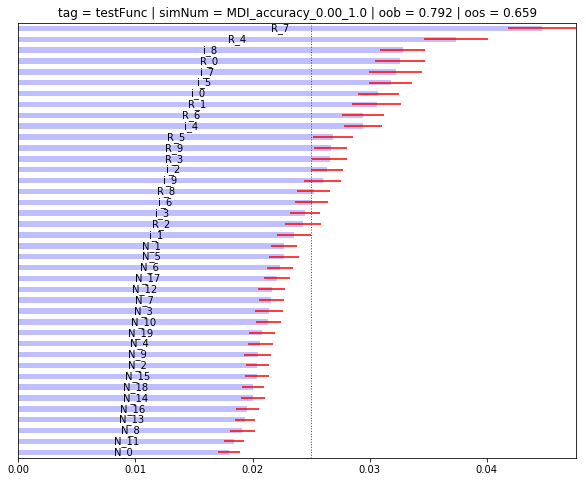

MDA_accuracy_0.00_1.0


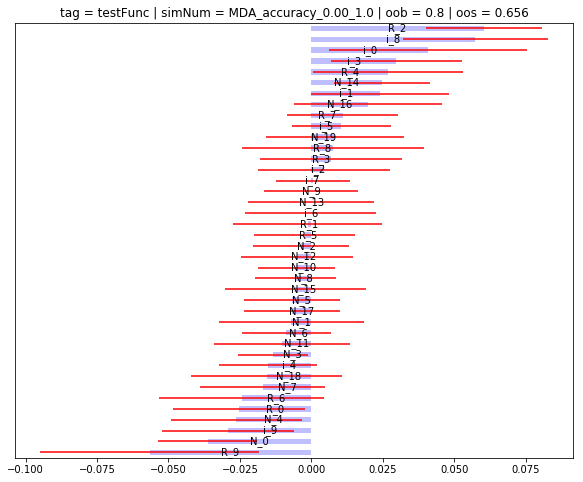

SFI_accuracy_0.00_1.0


2019-05-17 11:49:37.347474 4.17% auxFeatImpSFI done after 0.83 minutes. Remaining 19.16 minutes. \ r2019-05-17 11:49:37.452064 8.33% auxFeatImpSFI done after 0.83 minutes. Remaining 9.18 minutes. \ r2019-05-17 11:49:38.446480 12.5% auxFeatImpSFI done after 0.85 minutes. Remaining 5.96 minutes. \ r2019-05-17 11:49:39.536594 16.67% auxFeatImpSFI done after 0.87 minutes. Remaining 4.35 minutes. \ r2019-05-17 11:49:41.835514 20.83% auxFeatImpSFI done after 0.91 minutes. Remaining 3.45 minutes. \ r2019-05-17 11:49:42.648919 25.0% auxFeatImpSFI done after 0.92 minutes. Remaining 2.76 minutes. \ r2019-05-17 11:49:43.537426 29.17% auxFeatImpSFI done after 0.94 minutes. Remaining 2.27 minutes. \ r2019-05-17 11:49:44.713261 33.33% auxFeatImpSFI done after 0.96 minutes. Remaining 1.91 minutes. \ r2019-05-17 11:50:09.774402 37.5% auxFeatImpSFI done after 1.37 minutes. Remaining 2.29 minutes. \ r2019-05-17 11:50:10.035646 41.67% auxFeatImpSFI done after 1.38 minutes. Remaining 1.93 minutes. \ r2019

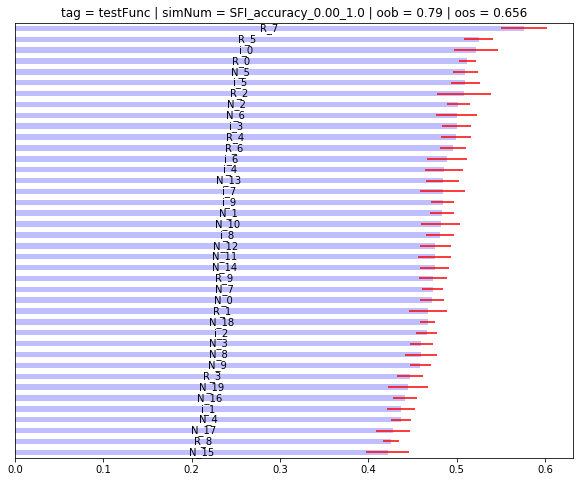

Index(['N', 'R', 'i', 'max_samples', 'method', 'minWLeaf', 'oob', 'oos',
       'scoring', 'simNum'],
      dtype='object')


In [10]:
testFunc(n_features=40,
         n_informative=10,
         n_redundant=10,
         n_estimators=100,
         n_samples=1000,
         cv=10)

In [ ]:
out['method', 'scoring', 'minWLeaf', 'max_samples', 'I', 'R', 'N', 'oob', 'oos']